In [1]:
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import math

from keras.models import Sequential 
from keras.layers import Dense 
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from keras.utils.np_utils import to_categorical
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import Normalizer

Using TensorFlow backend.


In [2]:
DATA_DIR = Path('.', 'data', 'final', 'public')
train_values = pd.read_csv(DATA_DIR / 'train_values.csv', index_col='building_id')
train_labels = pd.read_csv(DATA_DIR / 'train_labels.csv', index_col='building_id')
test_values = pd.read_csv(DATA_DIR / 'test_values.csv', index_col='building_id')

In [3]:
def inicializamodelo(caso):
    global legeo,lencoder,lencoder_col
    if 'legeo' in globals():
        del legeo
    if 'lencoder' in globals():    
        del lencoder
    if 'lencoder_col' in globals():
        del lencoder_col
    lencoder_col=list([])
    if caso == 1:
        legeo = LabelEncoder()
        lencoder= list([])
        print("Inicializa LabelEncoder caso 1")
    if caso == 2:
        legeo = LabelEncoder()
        lencoder= OneHotEncoder(handle_unknown='ignore', sparse=False)   
        print("Inicializa OneHotEncoder caso 2")

In [22]:
def prepros(ltrain,lytrain,caso):
    global legeo,lencoder,lencoder_col
    s = (ltrain.dtypes == 'object')
    object_cols = list(s[s].index)
    s = (ltrain.dtypes != 'object')
    number_cols = list(s[s].index)
    if caso == 1:
            inicializamodelo(caso)
            contador=0
            lsns_data=ltrain[number_cols].copy()
            for col in ltrain[object_cols].columns:
                lencoder.append(LabelEncoder())
                lencoder[contador].fit(ltrain[col])
                lsns_data[col]=lencoder[contador].transform(ltrain[col])  
                contador=contador+1
    if caso == -1:
            contador=0
            lsns_data=ltrain[number_cols].copy()
            for col in ltrain[object_cols].columns:
                lsns_data[col]=lencoder[contador].transform(ltrain[col])  
                contador=contador+1               
    if caso == 2:  
            inicializamodelo(caso)
            nada = lencoder.fit_transform(ltrain[object_cols])
            co1c=0
            for co1 in lencoder.categories_:
                for co2 in co1:
                    lencoder_col.append(object_cols[co1c]+"_"+co2)
                co1c=co1c+1
            lsns_data=pd.concat([ltrain[number_cols].copy(),
                                 pd.DataFrame(nada,columns=lencoder_col,
                                         index=ltrain[object_cols].index.tolist())],axis=1)
    if caso == -2:  
            lsns_data=ltrain[number_cols].copy()
            nada = lencoder.transform(ltrain[object_cols])
            lsns_data=pd.concat([ltrain[number_cols].copy(),
                                 pd.DataFrame(nada,columns=lencoder_col,
                                         index=ltrain[object_cols].index.tolist())],axis=1)        
    
    geo_level_1_fact=math.pow(10,int(math.log(lsns_data['geo_level_2_id'].max(),10)+1))
    geo_level_2_fact=math.pow(10,int(math.log(lsns_data['geo_level_3_id'].max(),10)+1))
    lsns_data['geo_level_n']=  lsns_data['geo_level_1_id']*geo_level_1_fact*geo_level_2_fact+lsns_data['geo_level_2_id']*geo_level_2_fact+lsns_data['geo_level_3_id']
    lsns_data['geo_level']=lsns_data['geo_level_n']#.astype(np.int64).astype(str)
    lsns_data['geo_level_2']=lsns_data['geo_level_n']*lsns_data['geo_level_n']
#    legeo.fit(lsns_data['geo_level'])
#    lsns_data['geo_level_cod']=legeo.transform(lsns_data['geo_level'])
    lsns_data['geo_level_cod']=lsns_data['geo_level_n'].astype(np.int64)
#    lsns_data=lsns_data.drop(['geo_level_1_id','geo_level_2_id','geo_level_3_id','geo_level_n','geo_level'],axis=1)
#    lsns_data=lsns_data.drop(['geo_level_2_id'],axis=1)

#    lsns_data['log_id']=lsns_data['geo_level_n'].apply( lambda x: np.log(x))
    lsns_data=lsns_data.drop(['geo_level_n','geo_level'],axis=1)

#    pdist = ltrain.join(lytrain).copy()
#    pdist['damage_grade_1']=pdist['damage_grade'].apply( lambda x: 1 if x == 1 else 0)
#    pdist['damage_grade_2']=pdist['damage_grade'].apply( lambda x: 100 if x == 2 else 0)
#    pdist['damage_grade_3']=pdist['damage_grade'].apply( lambda x: 10000 if x == 3 else 0)    
#    pdist=pdist[['geo_level_1_id','geo_level_2_id','geo_level_3_id','damage_grade_1','damage_grade_2','damage_grade_3']]
#    pdist=pdist.groupby(['geo_level_1_id','geo_level_2_id','geo_level_3_id']).sum()
#    pdist['damage_weitg']=pdist['damage_grade_1']+pdist['damage_grade_2']+pdist['damage_grade_3']
    
#    pdist=pdist.reset_index()
#    pdist=pdist.set_index(['geo_level_1_id','geo_level_2_id','geo_level_3_id'])
#    pdist=pdist.drop(['damage_grade_1','damage_grade_2','damage_grade_3'],axis=1)
#   lsns_data=lsns_data.join(pdist,on=['geo_level_1_id','geo_level_2_id','geo_level_3_id'])
 
#    lsns_data['old_age']=lsns_data['age'].apply( lambda x: 1 if x > 200 else 0)
   
    
    lsns_data=lsns_data.drop(['count_floors_pre_eq'],axis=1)
    lsytrain=lytrain
    min_max_scaler = MinMaxScaler()
    lsns_data[list(lsns_data.columns)]=min_max_scaler.fit_transform(lsns_data.values)
    lcolum_x = list(lsns_data.columns)
    return(lsns_data,lsytrain,lcolum_x)   

In [23]:
sns_data,nada,colum_x=prepros(train_values,train_labels,1)
sns_data.head(5)

Inicializa LabelEncoder caso 1


,geo_level_1_id,geo_level_2_id,geo_level_3_id,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,...,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,legal_ownership_status,geo_level_2,geo_level_cod
building_id,,,,,,,,,,,,,,,,,,,,,
802906,0.200000,0.341275,0.970637,0.030151,0.050505,0.100000,1.0,1.0,0.0,0.0,...,1.0,0.5,0.0,0.00,0.333333,1.000000,0.222222,0.666667,0.040278,0.200529
28830,0.266667,0.630694,0.223761,0.010050,0.070707,0.166667,0.0,1.0,0.0,0.0,...,0.5,0.5,0.0,0.75,0.333333,0.666667,0.222222,0.666667,0.072050,0.268272
94947,0.700000,0.254380,0.714013,0.010050,0.040404,0.100000,0.0,1.0,0.0,0.0,...,1.0,0.5,0.0,0.00,1.000000,1.000000,0.222222,0.666667,0.487167,0.697912
590882,0.733333,0.292922,0.850959,0.010050,0.050505,0.100000,0.0,1.0,0.0,0.0,...,1.0,0.5,0.0,0.00,1.000000,0.666667,0.222222,0.666667,0.534852,0.731280
201944,0.366667,0.091801,0.118405,0.030151,0.070707,0.233333,1.0,0.0,0.0,0.0,...,1.0,0.5,0.0,0.00,1.000000,0.666667,0.222222,0.666667,0.133524,0.365278


In [6]:
def cargamodelo(modelcaso):
    global model
    if modelcaso==1:
        model = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial',max_iter=500)
    if modelcaso==2:    
        model = RandomForestRegressor(max_depth=20, random_state=0,n_estimators=100)
    if modelcaso==3:
        model = DecisionTreeClassifier(random_state=0,max_depth=20) 
    if modelcaso==4:
        model = MultinomialNB
    if modelcaso==5:
        model = DecisionTreeRegressor(random_state=0)   
    if modelcaso==6:
        model = SVC(gamma='auto',verbose=True,kernel='linear', probability=True)          
    if modelcaso==9:    
        model = Sequential()
        model.add(Dense(12, input_dim=36, activation='relu'))
        model.add(Dense(30, activation='relu'))
        model.add(Dense(15, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
      

In [7]:
X_train, X_test, y_train, y_test = train_test_split(train_values, train_labels, test_size=0.33, random_state=42)

In [24]:
for mi in [2]:
    cargamodelo(mi)
    for micaso in [1]:
        pred_data,y_train1,colum_x=prepros(X_train,y_train,micaso)
        model.fit(pred_data,y_train1)
        lcolum_f = list(X_train.columns)
        test_data,y_test1,column_t=prepros(X_test,y_test,-micaso)
        f1=f1_score(y_test1, model.predict(test_data).round().astype(np.int64), average='micro')  
        print('Modelo',mi,'Caso:',micaso,'F1_score:',f1)

Inicializa LabelEncoder caso 1


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


Modelo 2 Caso: 1 F1_score: 0.7326364260049536


                                     Specs         Score
10  has_superstructure_cement_mortar_brick  12808.981494
14        has_superstructure_rc_engineered   9477.795693
13    has_superstructure_rc_non_engineered   5742.764204
6      has_superstructure_mud_mortar_stone   4614.376369
29                               roof_type   4281.765181
30                       ground_floor_type   3945.794661
19                 has_secondary_use_hotel   1898.204216
20                has_secondary_use_rental   1739.557476
35                             geo_level_2   1088.551600
17                       has_secondary_use   1028.269696
5             has_superstructure_adobe_mud    934.989858
12               has_superstructure_bamboo    724.020182
7            has_superstructure_stone_flag    712.248938
11               has_superstructure_timber    686.028720
9      has_superstructure_mud_mortar_brick    658.922355
8   has_superstructure_cement_mortar_stone    618.183455
0                           geo

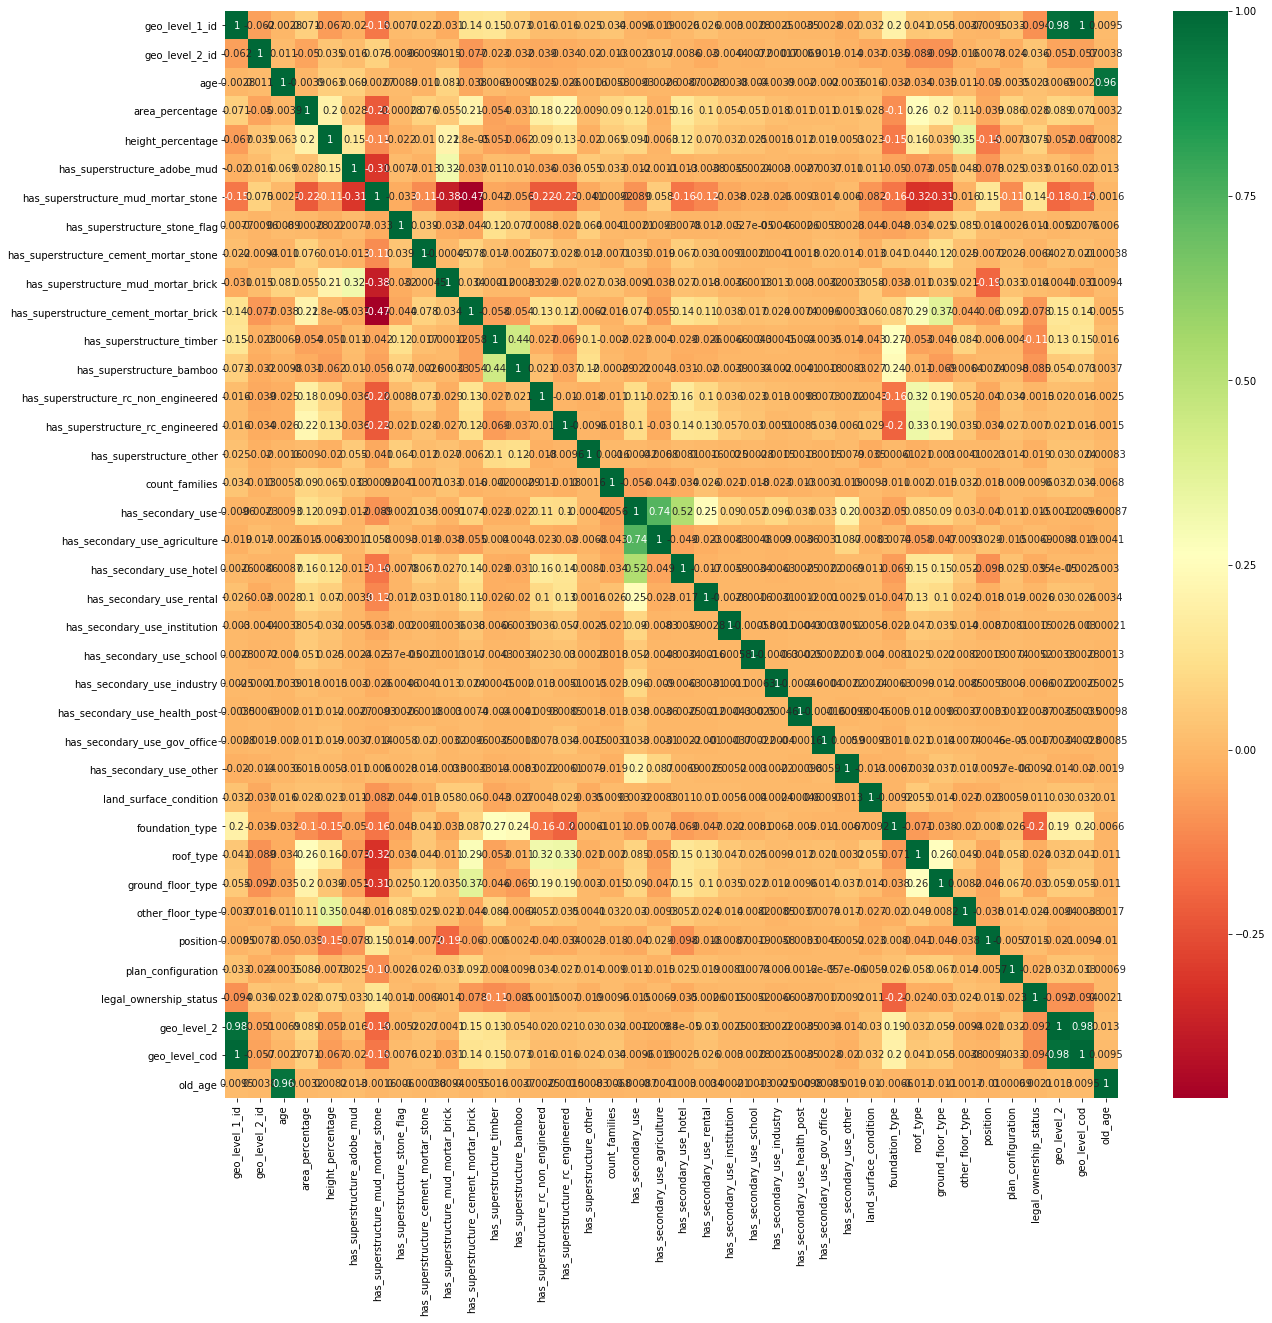

In [13]:
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(pred_data,y_train1)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(pred_data.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(60,'Score'))  #print 10 best features
corrmat = pred_data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(pred_data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [81]:
if 1==2:
    mimodelo=2
    micasof=1
    cargamodelo(mimodelo)
    pred_data,pred_label,colum_x=prepros(train_values,train_labels,micasof)
    model.fit(pred_data,pred_label)
    lcolum_f = list(test_values.columns)
    print('Shapes',pred_data.shape,pred_label.shape)
    pvalues,plabels,lcolum_f1=prepros(test_values,pd.DataFrame(test_values['geo_level_1_id'],columns=['damage_grade']),-micasof)
    print('Shapes',pvalues.shape,plabels.shape)
    pvalues['damage_grade']=model.predict(pvalues).round()
    pvalues=pvalues.drop(lcolum_f1,axis=1)
    pvalues.to_csv(DATA_DIR / 'submission_00_04.csv')
#test desde local

Inicializa LabelEncoder caso 1


c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Shapes (260601, 39) (260601, 1)


c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Shapes (86868, 39) (0, 1)
